#### Import necessary libraries

In [160]:
import kagglehub
import idx2numpy
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split, GridSearchCV
import matplotlib.pyplot as plt
import random as rd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
import pandas as pd
import seaborn as sns
import h5py
from joblib import load
from joblib import dump
import scipy.io
from skimage.color import rgb2gray
from skimage.transform import resize
from scipy.io import loadmat
import tensorflow_datasets as tfd
from sklearn.model_selection import GridSearchCV

#### Download MNIST digit dataset

In [161]:
# Download latest version
path = kagglehub.dataset_download("hojjatk/mnist-dataset")

print("Path to dataset files:", path)

Path to dataset files: C:\Users\DELL\.cache\kagglehub\datasets\hojjatk\mnist-dataset\versions\1


#### Load MNIST digit dataset

In [162]:
test_images_path = path + "\\test-images.idx3-ubyte"
test_labels_path = path + "\\test-labels.idx1-ubyte"
train_images_path = path + "\\train-images.idx3-ubyte"
train_labels_path = path + "\\train-labels.idx1-ubyte"

print(test_images_path)


# Load the IDX files
train_images = idx2numpy.convert_from_file(train_images_path)
train_labels = idx2numpy.convert_from_file(train_labels_path)
test_images = idx2numpy.convert_from_file(test_images_path)
test_labels = idx2numpy.convert_from_file(test_labels_path)

# Print the shape of the datasets
print(f"Training images shape: {train_images.shape}")
print(f"Training labels shape: {train_labels.shape}")
print(f"Test images shape: {test_images.shape}")
print(f"Test labels shape: {test_labels.shape}")

C:\Users\DELL\.cache\kagglehub\datasets\hojjatk\mnist-dataset\versions\1\test-images.idx3-ubyte
Training images shape: (60000, 28, 28)
Training labels shape: (60000,)
Test images shape: (10000, 28, 28)
Test labels shape: (10000,)


#### Reshape and normalize

In [163]:
# Reshape the images from (n, 28, 28) to (n, 28*28)
train_images = train_images.reshape(train_images.shape[0], -1)
test_images = test_images.reshape(test_images.shape[0], -1)

# Normalize the pixel values (0-255) to the range (0-1)
train_images = train_images / 255.0
test_images = test_images / 255.0

print(f"Train images reshaped and normalized: {train_images.shape}")
print(f"Test images reshaped and normalized: {test_images.shape}")


Train images reshaped and normalized: (60000, 784)
Test images reshaped and normalized: (10000, 784)


#### Evaluate different models for comparison

In [86]:
def evaluate_model(model, test_images, test_labels, model_name=None):
        
    # Make predictions
    predictions = model.predict(test_images)
    # Calculate metrics
    accuracy = accuracy_score(test_labels, predictions)
    precision = precision_score(test_labels, predictions, average='weighted')
    recall = recall_score(test_labels, predictions, average='weighted')
    f1 = f1_score(test_labels, predictions, average='weighted')
    # Confusion Matrix
    cm = confusion_matrix(test_labels, predictions)

    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'confusion_matrix': cm
    }


def compare_models(models, test_images, test_labels, models_names):
    results = []

    for model, model_name in zip(models, models_names):
        metrics = evaluate_model(model, test_images, test_labels)
        results.append({
            'model': model_name,
            **metrics
        })

    return pd.DataFrame(results)


                model  accuracy  precision  recall  f1_score  \
0                 SVC    0.9404   0.940474  0.9404  0.940281   
1  LogisticRegression    0.9261   0.925882  0.9261  0.925926   
2          KNeighbors    0.9688   0.969021  0.9688  0.968747   
3        DecisionTree    0.8772   0.877145  0.8772  0.877128   
4        RandomForest    0.9685   0.968530  0.9685  0.968486   
5          GaussianNB    0.5558   0.691726  0.5558  0.517042   

                                    confusion_matrix  
0  [[957, 0, 4, 1, 1, 6, 9, 1, 0, 1], [0, 1122, 3...  
1  [[958, 0, 1, 3, 1, 9, 4, 3, 1, 0], [0, 1111, 4...  
2  [[974, 1, 1, 0, 0, 1, 2, 1, 0, 0], [0, 1133, 2...  
3  [[914, 0, 9, 6, 5, 9, 16, 3, 9, 9], [2, 1090, ...  
4  [[970, 0, 1, 0, 0, 2, 3, 1, 3, 0], [0, 1123, 3...  
5  [[870, 0, 3, 5, 2, 5, 31, 1, 35, 28], [0, 1079...  


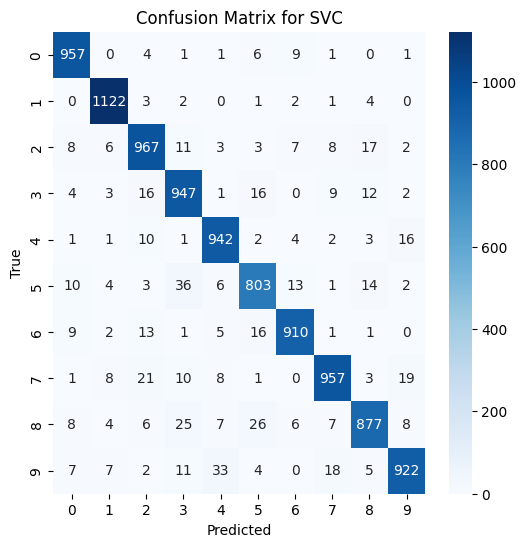

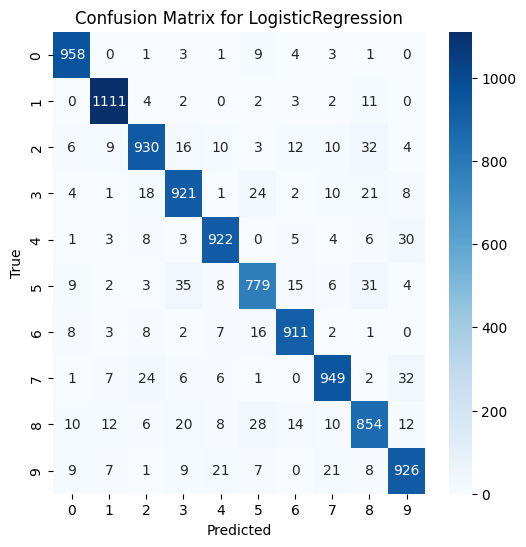

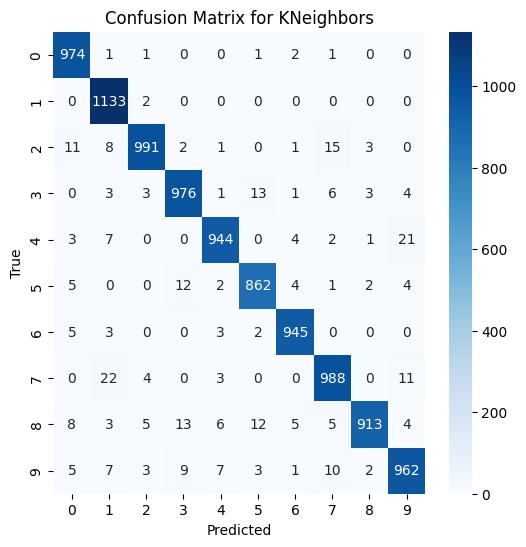

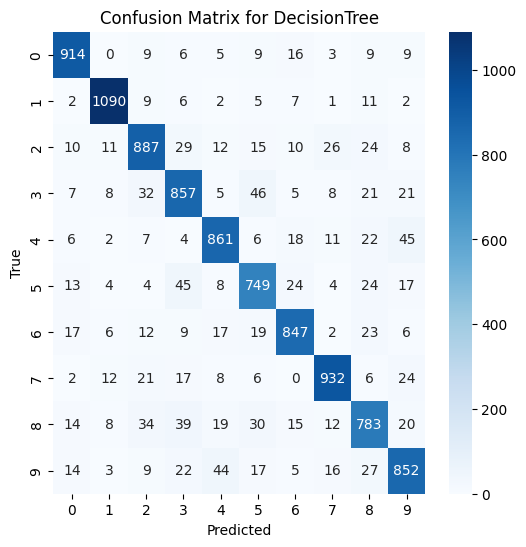

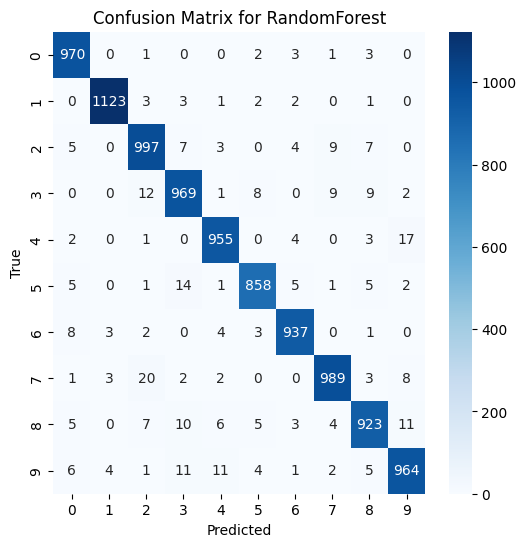

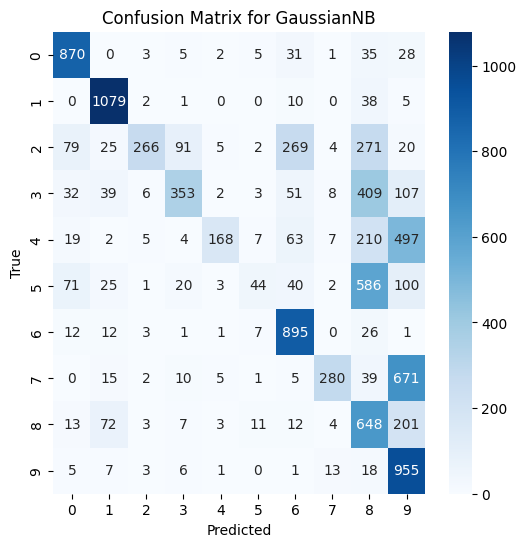

In [87]:

# List of models to evaluate
models_names = ["SVC", "LogisticRegression", "KNeighbors", "DecisionTree", "RandomForest", "GaussianNB"]
models = [
    SVC(kernel='linear'),
    LogisticRegression(max_iter=10000),
    KNeighborsClassifier(),
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    GaussianNB()
]


clfs = []
for m, name in zip(models, models_names):
        # Train the model
    clf = m.fit(train_images, train_labels)
    clfs.append(clf)
    
    # Save the model
    if name:
        dump(clf, f"{name}.joblib")

    
        


results_df = compare_models(models, test_images, test_labels, models_names)
print(results_df)

# Visualize confusion matrices for each model
for model_result in results_df.iterrows():
    _, row = model_result
    plt.figure(figsize=(6, 6))
    sns.heatmap(row['confusion_matrix'], annot=True, fmt='d', cmap='Blues')
    plt.title(f"Confusion Matrix for {row['model']}")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()


## Testing model's generalization 

### EMNIST dataset

In [141]:
# Load the CSV file
data = pd.read_csv('emnist-digits-test.csv')

test_emnist_labels = data.iloc[:, 0].values  # First column as labels
emnist_images = data.iloc[:, 1:].values   # Remaining columns as pixel values

# Reshape
emnist_images = emnist_images.reshape(-1, 28, 28)  # This assumes images are stored in rows

# for models expecting 1D input
test_emnist_images = emnist_images.reshape(-1, 784)  # Shape will be (n_samples, 784)



# Normalize the pixel values (0-255) to the range (0-1)
test_images = test_emnist_images / 255.0

print("Labels shape:", test_emnist_labels.shape)
print("Flattened Images shape:", test_emnist_images.shape)  # (number_of_samples, 784)

Labels shape: (39999,)
Flattened Images shape: (39999, 784)


#### Load trained models

In [138]:
clf_svc = load("SVC.joblib")
clf_logreg = load("LogisticRegression.joblib")
clf_knn = load("KNeighbors.joblib")
clf_dectree = load("DecisionTree.joblib")
clf_ranforest = load("RandomForest.joblib")
clf_naive = load("GaussianNB.joblib")

#### Evaluate and compare

                model  accuracy  precision    recall  f1_score  \
0                 SVC  0.170204   0.136293  0.170204  0.130648   
1  LogisticRegression  0.183805   0.135593  0.183805  0.137356   
2          KNeighbors  0.107603   0.109844  0.107603  0.033461   
3        DecisionTree  0.130578   0.116783  0.130578  0.117380   
4        RandomForest  0.164679   0.140051  0.164679  0.117179   
5          GaussianNB  0.120128   0.140589  0.120128  0.094162   

                                    confusion_matrix  
0  [[3401, 0, 129, 19, 9, 396, 6, 8, 18, 13], [63...  
1  [[3172, 0, 59, 109, 17, 539, 5, 19, 64, 15], [...  
2  [[3996, 0, 0, 0, 0, 0, 0, 0, 3, 0], [2461, 62,...  
3  [[1988, 92, 748, 32, 81, 233, 519, 30, 186, 90...  
4  [[3950, 0, 15, 1, 7, 3, 5, 0, 12, 6], [111, 13...  
5  [[97, 6, 1343, 101, 1837, 493, 0, 98, 5, 19], ...  


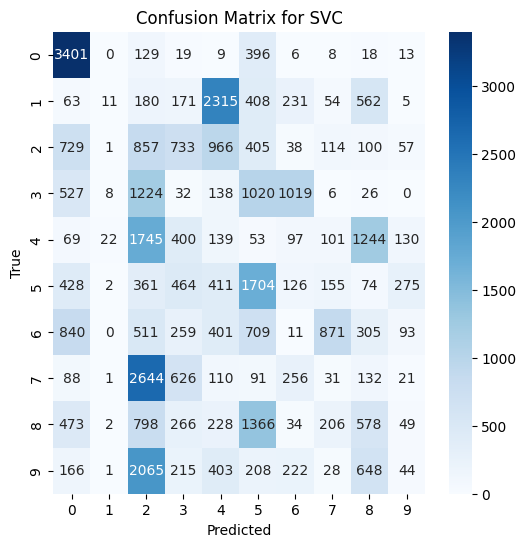

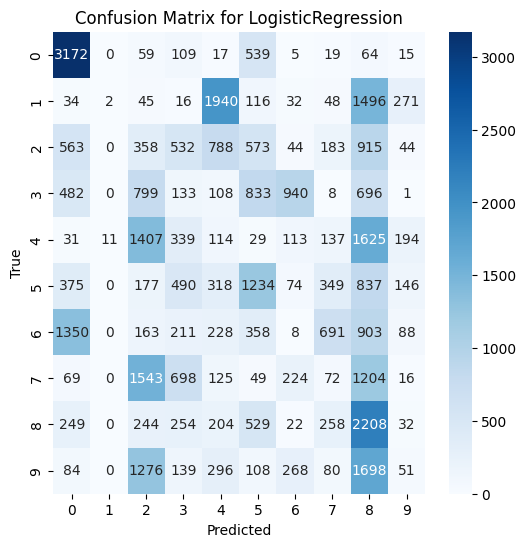

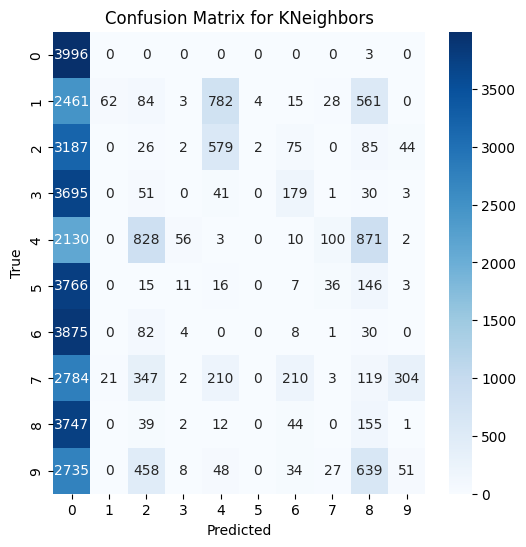

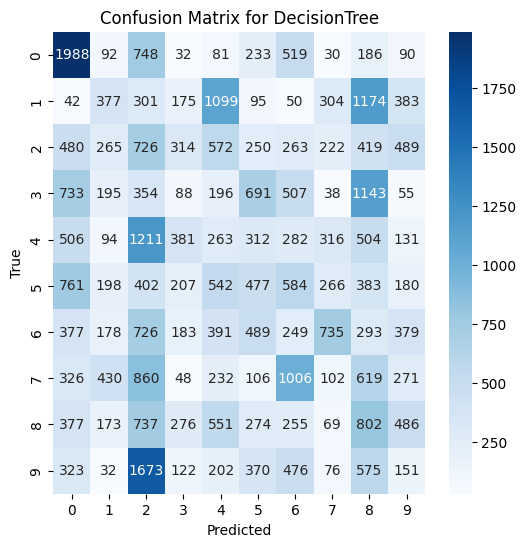

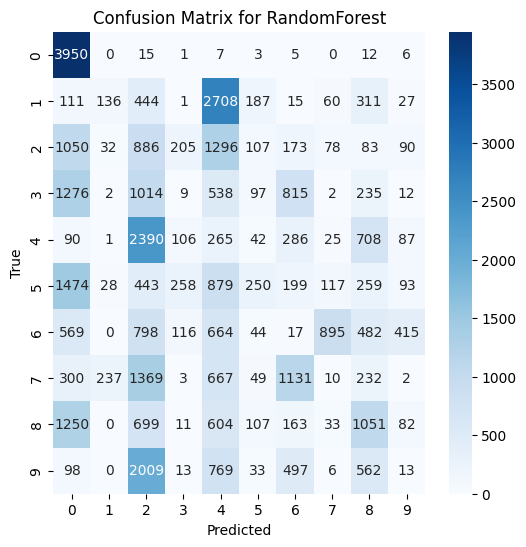

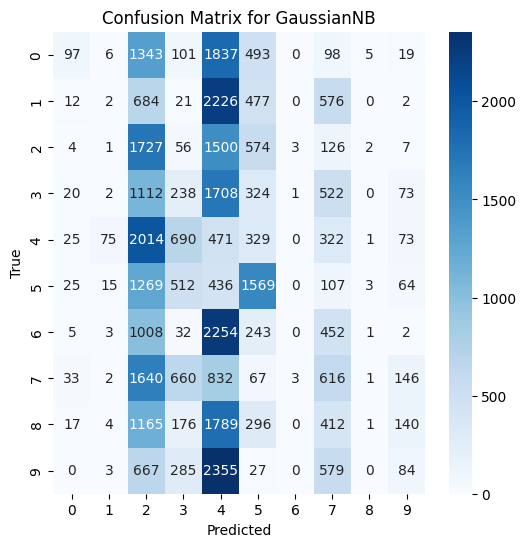

In [142]:
#models = [ clf_svc, clf_logreg, clf_knn, clf_dectree,clf_ranforest, clf_naive]

results_df = compare_models(models, test_emnist_images, test_emnist_labels, models_names)
print(results_df)

# Visualize confusion matrices for each model
for model_result in results_df.iterrows():
    _, row = model_result
    plt.figure(figsize=(6, 6))
    sns.heatmap(row['confusion_matrix'], annot=True, fmt='d', cmap='Blues')
    plt.title(f"Confusion Matrix for {row['model']}")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()


### USPS dataset

##### Downloading and importing USPS dataset

In [166]:
# Download latest version
path = kagglehub.dataset_download("bistaumanga/usps-dataset")

print("Path to dataset files:", path)

Path to dataset files: C:\Users\DELL\.cache\kagglehub\datasets\bistaumanga\usps-dataset\versions\1


##### Load USPS dataset

In [167]:
# Load files
path += r"\usps.h5"
with h5py.File(path, 'r') as hf:
        train = hf.get('train')
        X_tr = train.get('data')[:]
        y_tr = train.get('target')[:]
        test = hf.get('test')
        X_te = test.get('data')[:]
        y_te = test.get('target')[:]


#Print the shape of the datasets
print(f"Training images shape: {train_images.shape}")
print(f"Training labels shape: {train_labels.shape}")
print(f"Test images shape: {X_te.shape}")
print(f"Test labels shape: {y_te.shape}")

Training images shape: (60000, 784)
Training labels shape: (60000,)
Test images shape: (2007, 256)
Test labels shape: (2007,)


##### Resize images

In [168]:
from PIL import Image
import numpy as np

# Function to resize and flatten images
def resize_and_flatten_images(images, target_size=(28, 28)):
    resized_images = []
    for img in images:
        img_reshaped = img.reshape(16, 16)  # Reshape to 2D if needed
        img_resized = Image.fromarray(img_reshaped).resize(target_size)  # Resize to (28, 28)
        resized_images.append(np.array(img_resized).flatten())  # Flatten the image
    return np.array(resized_images)

# Resize and flatten test images
X_tr = resize_and_flatten_images(X_tr)
X_te = resize_and_flatten_images(X_te)

##### Load saved models

In [91]:
clf_svc = load("SVC.joblib")
clf_logreg = load("LogisticRegression.joblib")
clf_knn = load("KNeighbors.joblib")
clf_dectree = load("DecisionTree.joblib")
clf_ranforest = load("RandomForest.joblib")
clf_naive = load("GaussianNB.joblib")

#### Evaluate and compare

C:\Users\DELL\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\DELL\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


                model  accuracy  precision    recall  f1_score  \
0                 SVC  0.238166   0.496181  0.238166  0.213479   
1  LogisticRegression  0.143000   0.311219  0.143000  0.098676   
2          KNeighbors  0.671649   0.661039  0.671649  0.647562   
3        DecisionTree  0.338316   0.402836  0.338316  0.351416   
4        RandomForest  0.603388   0.647634  0.603388  0.580461   
5          GaussianNB  0.128550   0.063347  0.128550  0.071356   

                                    confusion_matrix  
0  [[11, 0, 192, 117, 1, 38, 0, 0, 0, 0], [0, 122...  
1  [[0, 0, 53, 284, 1, 20, 0, 0, 1, 0], [0, 2, 0,...  
2  [[327, 1, 6, 11, 2, 4, 1, 5, 2, 0], [0, 253, 0...  
3  [[175, 1, 120, 7, 1, 11, 30, 5, 6, 3], [1, 107...  
4  [[331, 0, 5, 9, 1, 9, 0, 0, 4, 0], [1, 114, 2,...  
5  [[0, 10, 144, 55, 91, 46, 0, 8, 0, 5], [0, 3, ...  


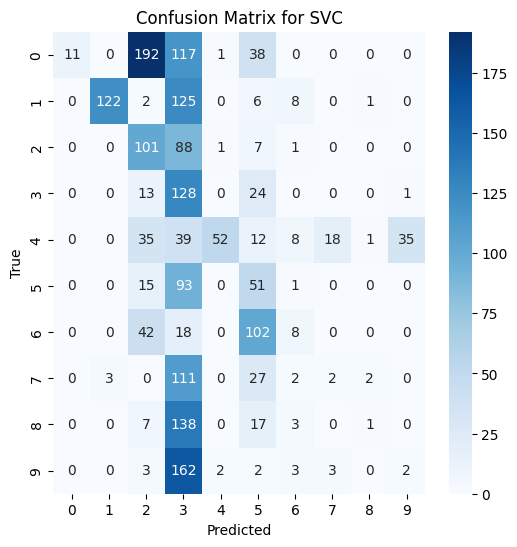

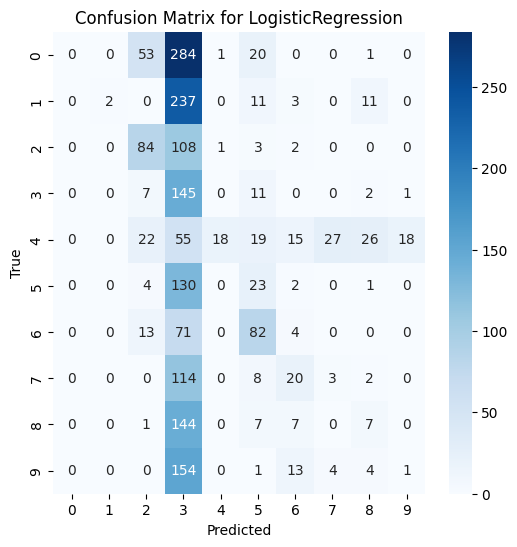

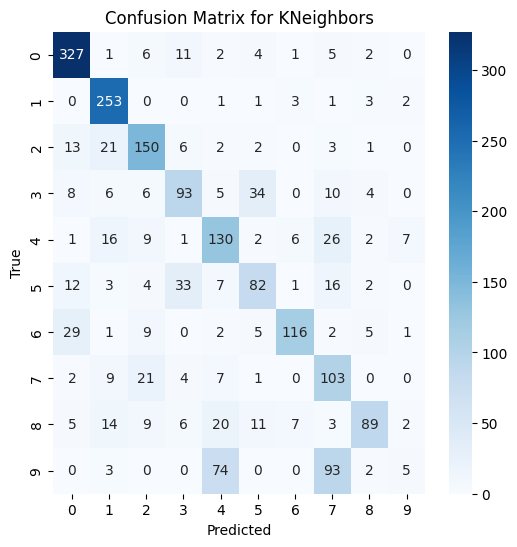

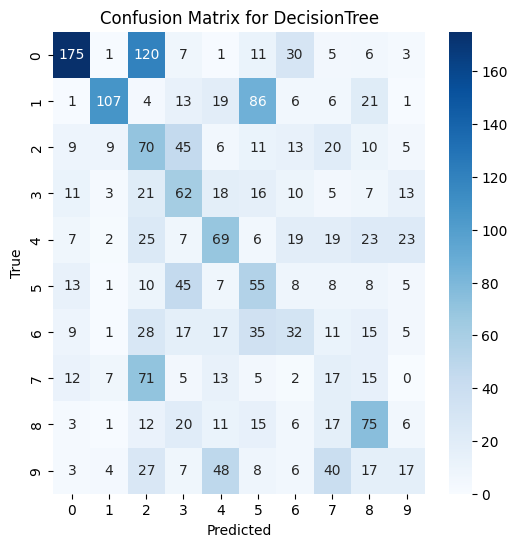

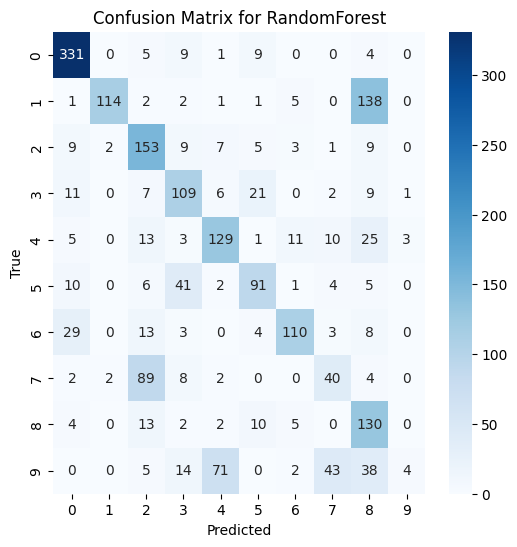

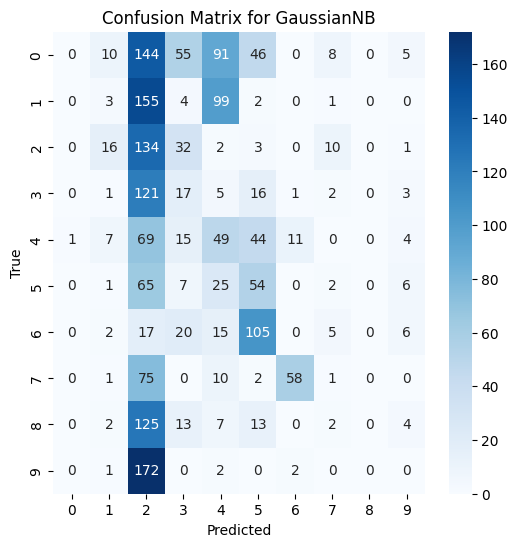

In [92]:
#models = [ clf_svc, clf_logreg, clf_knn, clf_dectree,clf_ranforest, clf_naive]

results_df = compare_models(models, X_te, y_te, models_names)
print(results_df)

# Visualize confusion matrices for each model
for model_result in results_df.iterrows():
    _, row = model_result
    plt.figure(figsize=(6, 6))
    sns.heatmap(row['confusion_matrix'], annot=True, fmt='d', cmap='Blues')
    plt.title(f"Confusion Matrix for {row['model']}")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()


### The Street View House Numbers (SVHN) Dataset

In [111]:
# Load the .mat file
mat = loadmat('test_32x32.mat')

# Extract the images and labels
X = mat['X']  # 32x32x3x2007 (width, height, channels, num_images)
y = mat['y']  # labels (2007,)

# Reshape the X array (32, 32, 3, num_images) -> (num_images, 32, 32, 3)
X = np.moveaxis(X, -1, 0)

# Convert to grayscale and resize to 28x28
X_resized = []
for img in X:
    gray_img = rgb2gray(img)  # Convert to grayscale
    resized_img = resize(gray_img, (28, 28), anti_aliasing=True)  # Resize to 28x28
    X_resized.append(resized_img.flatten())  # Flatten  28x28 --> 784

# Convert to numpy arr
X_resized = np.array(X_resized)

# Ensure labels are correctly formatted
y = y.flatten()
y[y == 10] = 0  # label '10' corresponds to '0' 

# Final shapes
print(f'X_test shape: {X_resized.shape}')  
print(f'y_test shape: {y.shape}')          

X_test shape: (26032, 784)
y_test shape: (26032,)


C:\Users\DELL\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\DELL\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\DELL\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.

                model  accuracy  precision    recall  f1_score  \
0                 SVC  0.158651   0.381624  0.158651  0.065896   
1  LogisticRegression  0.123002   0.081524  0.123002  0.066480   
2          KNeighbors  0.190957   0.271526  0.190957  0.199880   
3        DecisionTree  0.090005   0.241265  0.090005  0.062172   
4        RandomForest  0.060426   0.055197  0.060426  0.018168   
5          GaussianNB  0.144899   0.108319  0.144899  0.068061   

                                    confusion_matrix  
0  [[2, 0, 1542, 151, 0, 49, 0, 0, 0, 0], [0, 1, ...  
1  [[0, 0, 579, 820, 0, 342, 0, 3, 0, 0], [0, 0, ...  
2  [[749, 206, 115, 54, 136, 107, 112, 25, 207, 3...  
3  [[81, 0, 525, 77, 17, 12, 0, 23, 529, 480], [1...  
4  [[77, 0, 25, 0, 0, 0, 4, 0, 1638, 0], [221, 0,...  
5  [[0, 12, 1264, 233, 7, 26, 2, 200, 0, 0], [0, ...  


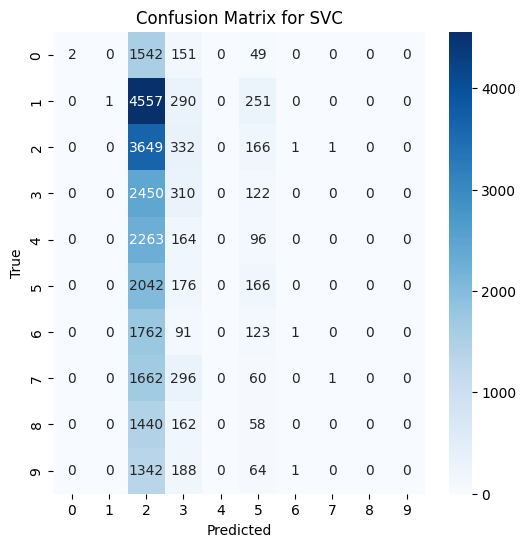

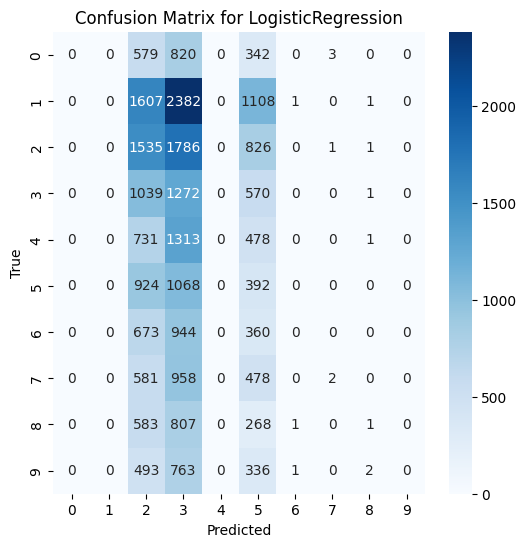

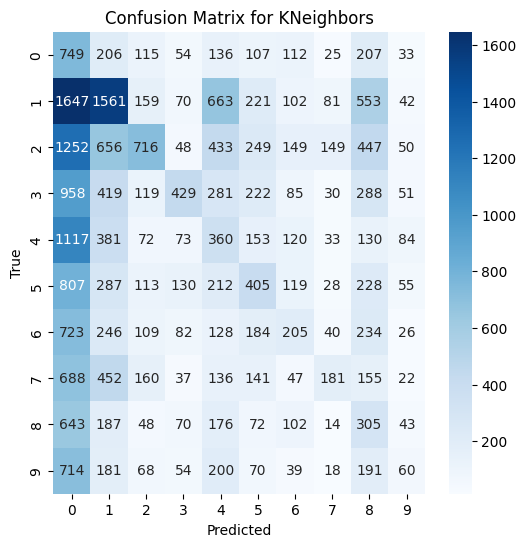

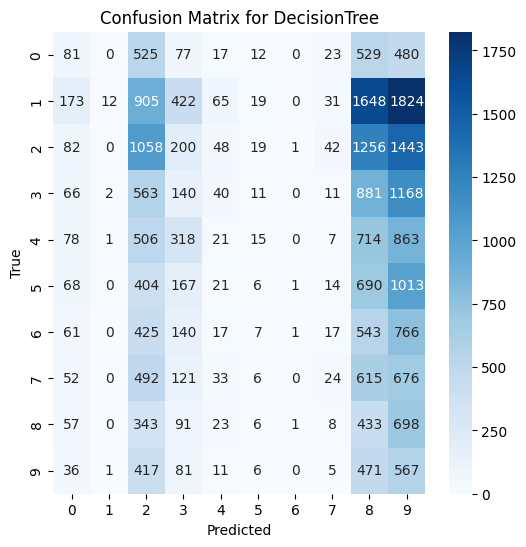

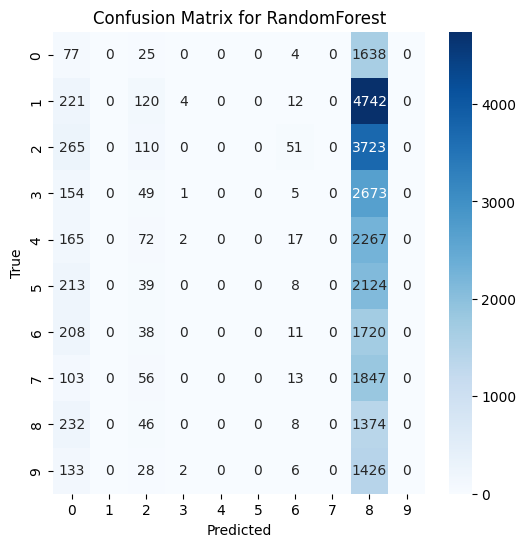

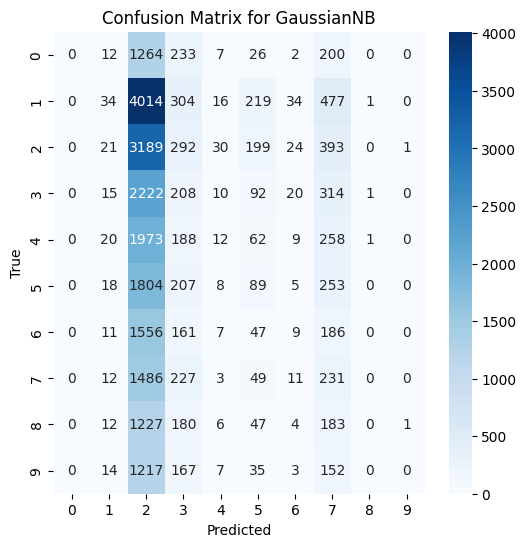

In [112]:
results_df = compare_models(models, X_resized, y, models_names)
print(results_df)

# Visualize confusion matrices for each model
for model_result in results_df.iterrows():
    _, row = model_result
    plt.figure(figsize=(6, 6))
    sns.heatmap(row['confusion_matrix'], annot=True, fmt='d', cmap='Blues')
    plt.title(f"Confusion Matrix for {row['model']}")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

#### Upgrading model

Now lets partially train the KNN model with the MNIST dataset and the USPS dataset to try and get a better performance.

In [170]:
# Combine the datasets for training
combined_train_images = np.concatenate((train_images, X_tr), axis=0)
combined_train_labels = np.concatenate((train_labels, y_tr), axis=0)

# Initialize the KNeighborsClassifier model
model_double = KNeighborsClassifier()

# Train on the combined dataset
model_double.fit(combined_train_images, combined_train_labels)

# Evaluate on test dataset (e.g., MNIST test data)
print("Accuracy with MNIST dataset after training on both datasets:", model_double.score(test_images, test_labels))

# Evaluate on test dataset (e.g., MNIST test data)
print("Accuracy with USPS dataset after training on both datasets:", model_double.score(X_te, y_te))



# Save the trained model
dump(model_double, "KNN_MNIST_USPS.joblib")


Accuracy with MNIST dataset after training on both datasets: 0.9688
Accuracy with USPS dataset after training on both datasets: 0.9466865969108121


['KNN_MNIST_USPS.joblib']

In [173]:

# Evaluate on test dataset (e.g., MNIST test data)
print("Accuracy with EMNIST dataset after training on both datasets:", model_double.score(test_emnist_images, test_emnist_labels))

# Evaluate on test dataset (e.g., MNIST test data)
print("Accuracy with SVHN  dataset after training on both datasets:", model_double.score(X_resized, y))




Accuracy with USPS dataset after training on both datasets: 0.10460261506537663
Accuracy with USPS dataset after training on both datasets: 0.15676859250153657


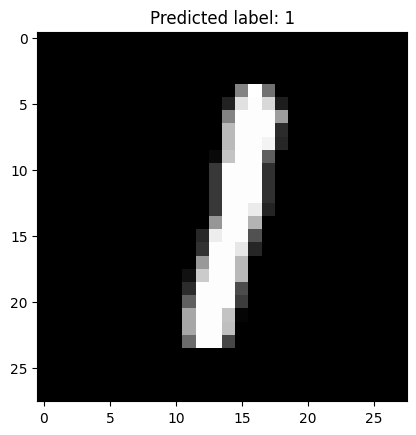

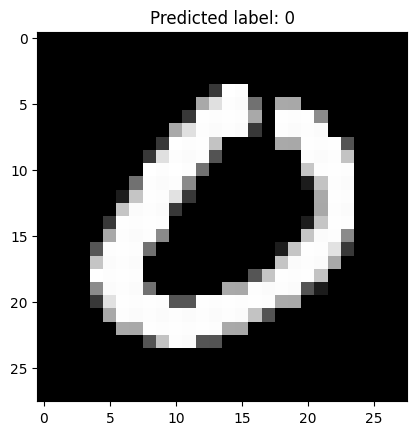

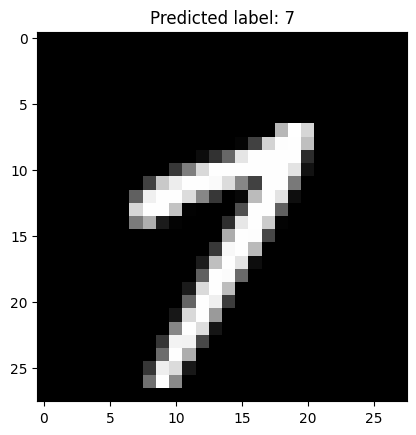

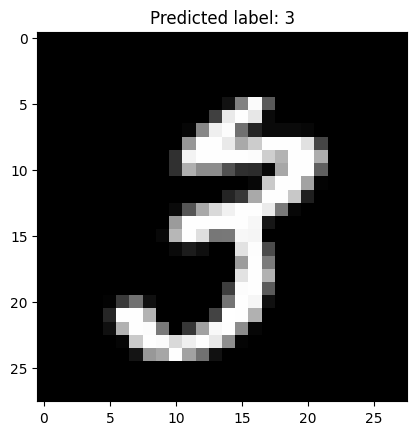

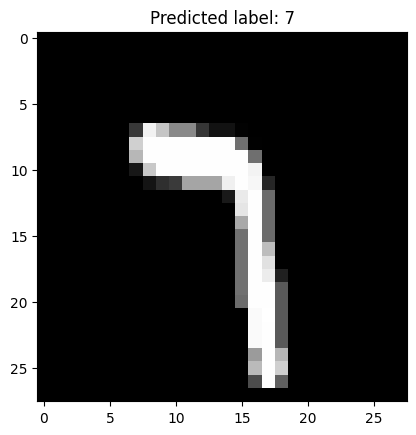

In [96]:
import matplotlib.pyplot as plt
import random as rd
# Select a random test image and its predicted label


for i in range(5):
    index = rd.randint(0,len(test_images))    # You can change this index to see different images
    plt.imshow(test_images[index].reshape(28, 28), cmap='gray')
    plt.title(f"Predicted label: {predictions[index]}")
    plt.show()
